# ANKRD11

[KBG syndrome (KBGS)](https://omim.org/entry/148050) is caused by heterozygous mutation in the ANKRD11 gene. In this notebook, we have used
[pyphetools](https://github.com/monarch-initiative/pyphetools) to parse the clinical data included in the supplemental files of
[Martinez-Cayuelas E, et al. Clinical description, molecular delineation and genotype-phenotype correlation in 340 patients with KBG syndrome: addition of 67 new patients](https://pubmed.ncbi.nlm.nih.gov/36446582).

In [1]:
import hpotk
import gpsea

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}');
print(f"Using gpsea version {gpsea.__version__}");

Loaded HPO v2025-01-16
Using gpsea version 0.9.6.dev0


### ANKRD11
We used the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for ANKRD11.

In [2]:
from gpsea.preprocessing import configure_default_protein_metadata_service

gene_symbol = 'ANKRD11'
mane_tx_id = 'NM_013275.6'
mane_protein_id = 'NP_037407.4' # ankyrin repeat domain-containing protein 11 [Homo sapiens]
pms = configure_default_protein_metadata_service()
protein_meta = pms.annotate(mane_protein_id)

In [4]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store("0.1.24") as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))
print(f'Loaded {len(phenopackets)} phenopackets')
cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets(  
    phenopackets=phenopackets,
    cohort_creator=cohort_creator,
)

Loaded 337 phenopackets
Individuals Processed: 100%|██████████| 337/337 [01:35<00:00,  3.54 individuals/s]


In [5]:
from gpsea.view import CohortViewer

cv = CohortViewer(hpo)
cv.process(cohort, transcript_id=mane_tx_id)

n,HPO Term
211,Macrodontia
194,Intellectual disability
189,Abnormality of the hand
176,Global developmental delay
160,Delayed speech and language development
150,Short stature
126,Thick eyebrow
121,Long philtrum
89,Bulbous nose
83,Triangular face


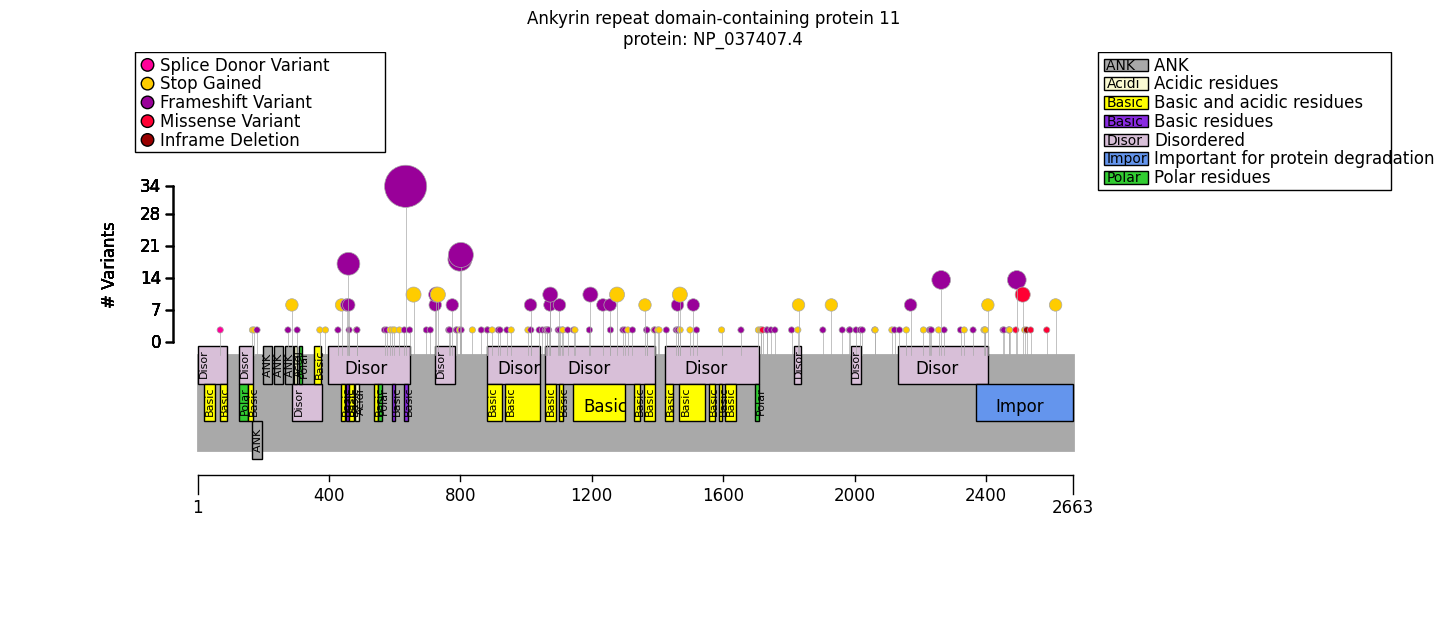

In [6]:
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

ankrd11_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein(
    protein_metadata=protein_meta,
    cohort=cohort,
    ax=ax,
)
ankrd11_fig.tight_layout()

In [7]:
from gpsea.view import ProteinVariantViewer
viewer = ProteinVariantViewer(protein_metadata=protein_meta, tx_id=mane_tx_id)
viewer.process(cohort)

Count,Name,Type,Coordinates,Variants
0,Disordered,Region,2 - 90,
0,Basic and acidic residues,Compositional bias,22 - 54,
0,Basic and acidic residues,Compositional bias,70 - 90,
1,Disordered,Region,129 - 169,p.Glu169Ter
0,Polar residues,Compositional bias,129 - 155,
1,Basic and acidic residues,Compositional bias,157 - 169,p.Glu169Ter
3,ANK 1,Repeat,168 - 196,p.Arg174Ter; p.Arg183ProfsTer44; p.Glu169Ter
0,ANK 2,Repeat,201 - 229,
0,ANK 3,Repeat,234 - 262,
3,ANK 4,Repeat,267 - 292,p.Tyr289Ter; p.Thr278ArgfsTer3


# Strategy
Here, we will perform a version of the tests based on tests performed in [Martinez-Cayuelas E,et al., (2023) Clinical description, molecular delineation and genotype-phenotype correlation in 340 patients with KBG syndrome: addition of 67 new patients. J Med Genet](https://pubmed.ncbi.nlm.nih.gov/36446582/).

The authors identified a significantly higher frequency of patients with a triangular face in carriers of sequence variants compared to CNVs. Other associations found were short stature and variants in exon 9, a lower incidence of ID/ADHD/ASD in carriers of the c.1903_1907del variant and the size of the deletion, in CNV carriers, with the presence of macrodontia and hand anomalies.

We note that the authors did not apply multiple-testing correction. 

In [8]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
analysis = configure_hpo_term_analysis(hpo)

from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest
pheno_clfs = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [9]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate import variant_effect 
from gpsea.analysis.clf import monoallelic_classifier
from gpsea.view import MtcStatsViewer

cnv = variant_effect(VariantEffect.TRANSCRIPT_ABLATION, mane_tx_id)
cnv_clf = monoallelic_classifier(a_predicate=cnv,
                                     b_predicate=~cnv,
                                     a_label="SV",
                                     b_label="other")
cnv_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=cnv_clf,
    pheno_clfs=pheno_clfs,
)

viewer = MtcStatsViewer()
viewer.process(cnv_result)

Reason,Count
Skip terms if all counts are identical to counts for a child term,8
"Skipping ""general"" level terms",53
Skipping terms that are rare on the cohort level (in less than 40% of the cohort members),119


In [10]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=cnv_result)

Allele group,SV,other,Corrected p values,p values
Ventricular septal defect [HP:0001629],6/28 (21%),12/146 (8%),0.617157,0.046588
Patent foramen ovale [HP:0001655],3/28 (11%),3/146 (2%),0.617157,0.053666
Microcephaly [HP:0000252],8/47 (17%),34/119 (29%),0.879437,0.165240
Pulmonic stenosis [HP:0001642],2/28 (7%),3/146 (2%),0.879437,0.183230
Short stature [HP:0004322],32/63 (51%),118/196 (60%),0.879437,0.191182
Atrioventricular canal defect [HP:0006695],0/28 (0%),9/146 (6%),1.000000,0.357959
Long philtrum [HP:0000343],13/18 (72%),108/134 (81%),1.000000,0.532058
Intellectual disability [HP:0001249],32/35 (91%),162/188 (86%),1.000000,0.584670
Bicuspid aortic valve [HP:0001647],1/28 (4%),4/147 (3%),1.000000,0.586402
Global developmental delay [HP:0001263],41/42 (98%),135/142 (95%),1.000000,0.684570


In [11]:
from gpsea.analysis.predicate import exon

ex9 = exon(exon=9, tx_id=mane_tx_id)
ex9_clf = monoallelic_classifier(a_predicate=ex9,
                                     b_predicate=~ex9,
                                     a_label="exon 9",
                                     b_label="other")
ex9_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=ex9_clf,
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo=hpo, result=ex9_result)

Allele group,exon 9,other,Corrected p values,p values
Long philtrum [HP:0000343],113/140 (81%),8/12 (67%),1.0,0.266364
Intellectual disability [HP:0001249],171/199 (86%),23/24 (96%),1.0,0.329975
Global developmental delay [HP:0001263],164/171 (96%),12/13 (92%),1.0,0.450135
Short stature [HP:0004322],138/235 (59%),12/24 (50%),1.0,0.515732
Feeding difficulties [HP:0011968],63/149 (42%),7/13 (54%),1.0,0.561160
Ventricular septal defect [HP:0001629],18/162 (11%),0/12 (0%),1.0,0.616251
Delayed speech and language development [HP:0000750],151/176 (86%),9/11 (82%),1.0,0.661736
Microcephaly [HP:0000252],39/156 (25%),3/10 (30%),1.0,0.714586
Macrodontia [HP:0001572],191/241 (79%),20/24 (83%),1.0,0.793604
Thick eyebrow [HP:0000574],113/139 (81%),13/16 (81%),1.0,1.000000


In [12]:
from gpsea.analysis.predicate import variant_key

k635_var = variant_key("16_89284634_89284639_GTGTTT_G") # c.1903_1907del	p.Lys635GlnfsTer26
k635_clf = monoallelic_classifier(a_predicate=k635_var,
                                     b_predicate=~k635_var,
                                     a_label="c.1903_1907del",
                                     b_label="other")
k635_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=k635_clf,
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo=hpo, result=k635_result)

Allele group,c.1903_1907del,other,Corrected p values,p values
Intellectual disability [HP:0001249],14/19 (74%),180/204 (88%),1.0,0.081289
Ventricular septal defect [HP:0001629],4/21 (19%),14/153 (9%),1.0,0.240368
Long philtrum [HP:0000343],12/13 (92%),109/139 (78%),1.0,0.469225
Global developmental delay [HP:0001263],15/16 (94%),161/168 (96%),1.0,0.524169
Short stature [HP:0004322],12/23 (52%),138/236 (58%),1.0,0.659344
Delayed speech and language development [HP:0000750],13/16 (81%),147/171 (86%),1.0,0.707451
Thick eyebrow [HP:0000574],10/13 (77%),116/142 (82%),1.0,0.710921
Pulmonic stenosis [HP:0001642],0/21 (0%),5/153 (3%),1.0,1.000000
Bicuspid aortic valve [HP:0001647],0/21 (0%),5/154 (3%),1.0,1.000000
Patent foramen ovale [HP:0001655],0/21 (0%),6/153 (4%),1.0,1.000000


# ANKRD11 phenotypical score
[Martinez-Cayuelas et al. (2023)](https://pubmed.ncbi.nlm.nih.gov/36446582/) defined a phenotype score with 17 variables: ten from neurodevelopment and and phenotype categories, and seven main comorbidities. We did not attempt to exactly replicate the score, which involved some postprocessing of the raw data (e.g., up to one point was given from Characteristic nose, defined as anteverted nares, and/or bulbous tip, and/or prominent nose). If desired, one can implement rules such as this in a custom class (see the DeVries scorer in GPSEA). We reasoned that a similar simpler score would also yield a significant result if the signal was genuine.  The authors note that their phenotypical score was significantly higher in patients with sequence variants as compared with CNVs.

We implement our version of the ANKRD11 phenotypical score using the CountingPhenotypeScorer. This class assigns one point if one or more HPO annotations in an individual matches a target term. The score thus ranges from zero to the total number of target terms.

In [13]:
from gpsea.analysis.pscore import CountingPhenotypeScorer
gdd = hpotk.TermId.from_curie("HP:0001263") # Global developmental delay
md = hpotk.TermId.from_curie("HP:0001270") # Motor delay
sld = hpotk.TermId.from_curie("HP:0000750") # Delayed speech and language development
id = hpotk.TermId.from_curie("HP:0001249") # Intellectual disability
macrodontia = hpotk.TermId.from_curie("HP:0001572") # Macrodontia
anteverted_nares = hpotk.TermId.from_curie("HP:0000463") # Anteverted nares
bulbous_nose = hpotk.TermId.from_curie("HP:0000414") # Bulbous nose
hearing = hpotk.TermId.from_curie("HP:0000365") # Hearing impairment
otitis  = hpotk.TermId.from_curie("HP:0000403") # Recurrent otitis media
visual  = hpotk.TermId.from_curie("HP:0000505") # Visual impairment 
heart   = hpotk.TermId.from_curie("HP:0001627") # Abnormal heart morphology, approximation
seizure = hpotk.TermId.from_curie("HP:0001250") # Seizure  
feeding = hpotk.TermId.from_curie("HP:0011968") # Feeding difficulties
crypt = hpotk.TermId.from_curie("HP:0000028")   # Cryptorchidism 
adhd = hpotk.TermId.from_curie("HP:0007018") # Attention deficit hyperactivity disorder
aut_behavior = hpotk.TermId.from_curie("HP:0000729") # Autistic behavior
tooth = hpotk.TermId.from_curie("HP:0006482") # Abnormal dental morphology
triangular = hpotk.TermId.from_curie("HP:0000325") #Triangular face 
philtrum = hpotk.TermId.from_curie("HP:0000343") # Long philtrum 
low_set_ear = hpotk.TermId.from_curie("HP:0000369") # Low-set ears
hand = hpotk.TermId.from_curie("HP:0005922") # Abnormal hand morphology 
short = hpotk.TermId.from_curie("HP:0004322") #  Short stature 
ankrd11_score = [gdd, md, sld, id, macrodontia, anteverted_nares, bulbous_nose, hearing, otitis, visual, heart, seizure, feeding, crypt, adhd, aut_behavior, tooth, triangular, philtrum, hand, short]

count_scorer = CountingPhenotypeScorer(hpo=hpo, query=ankrd11_score)

In [14]:
from gpsea.analysis.pscore.stats import MannWhitneyStatistic
score_statistic = MannWhitneyStatistic()
from gpsea.analysis.pscore import PhenotypeScoreAnalysis
score_analysis = PhenotypeScoreAnalysis(
    score_statistic=score_statistic,
)

score_result = score_analysis.compare_genotype_vs_phenotype_score(
    cohort=cohort,
    gt_clf=cnv_clf,
    pheno_scorer=count_scorer,
)
p_value_text = f"ANKRD11 phenotype score: p={score_result.pval:.4f}"
print(p_value_text)

ANKRD11 phenotype score: p=0.0003


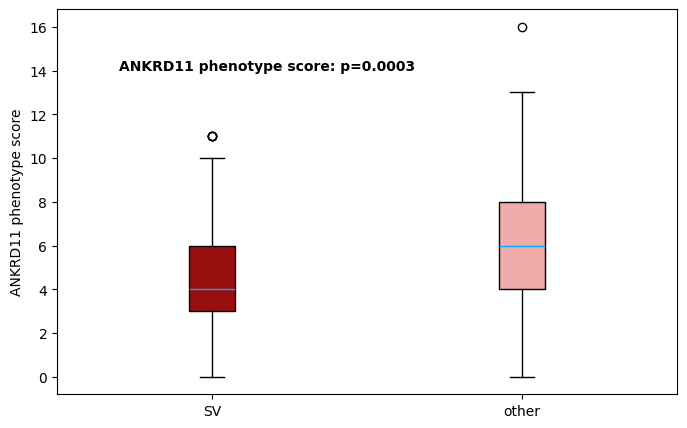

In [15]:
import matplotlib.pyplot as plt
ANKRD11_phenoscore_fig, ax = plt.subplots(figsize=(8, 5))

ax.text(0.7, 14, p_value_text, weight='bold')
ax.set_ylabel("ANKRD11 phenotype score")

score_result.plot_boxplots(ax=ax)

In [16]:
df = score_result.data
group0_mean = df[df["genotype"] == 0]["phenotype"].mean()
group1_mean = df[df["genotype"] == 1]["phenotype"].mean()
score_interpretation = f"AKKRD11 phenotype score for structural variants: {group0_mean:.2f}, and for other variants: {group1_mean:.2f}"
print(score_interpretation)

AKKRD11 phenotype score for structural variants: 4.62, and for other variants: 5.94


In [17]:
from gpsea.analysis.clf import sex_classifier
mf_result = score_analysis.compare_genotype_vs_phenotype_score(
    cohort=cohort,
    gt_clf=sex_classifier(),
    pheno_scorer=count_scorer,
)
p_value_text = f"M/F score: p={mf_result.pval:.4f}"
df = mf_result.data
# Note that female is represented as 0 and male as 1
group0_mean = df[df["genotype"] == 0]["phenotype"].mean()
group1_mean = df[df["genotype"] == 1]["phenotype"].mean()
score_interpretation = f"ANKRD11 phenotype score (male/female comparison): Female {group0_mean:.2f}, Male: {group1_mean:.2f}: p={mf_result.pval:.4f}"

print(score_interpretation)

ANKRD11 phenotype score (male/female comparison): Female 5.28, Male: 6.15: p=0.0075


# Summary

In [18]:
from gpseacs.report import GpseaAnalysisReport, GPAnalysisResultSummary


M_results = (
    GPAnalysisResultSummary.from_mono(
        result=score_result,
        xrefs={
            'ANKRD11 score': ('PMID: 36446582'),
        },
        interpretation=score_interpretation
    ),
    GPAnalysisResultSummary.from_mono(
        result=mf_result,
    )
)

F_results = (
    GPAnalysisResultSummary.from_multi(
         result=cnv_result,
    ),
    GPAnalysisResultSummary.from_multi(
        result=ex9_result,
    ),
    GPAnalysisResultSummary.from_multi(
        result=k635_result,
    )
)

ankrd11_caption = "Validated results on ANKRD11 phenotypical score. Other results did not survive multiple testing correction."
report = GpseaAnalysisReport(name=gene_symbol, 
                             cohort=cohort, 
                             mono_results=M_results,
                             fet_results=F_results,
                             gene_symbol=gene_symbol,
                             mane_tx_id=mane_tx_id,
                             mane_protein_id=mane_protein_id,
                             caption=ankrd11_caption)

In [19]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

In [20]:
summarizer.process_latex(report=report, protein_fig=ankrd11_fig, stats_fig=ANKRD11_phenoscore_fig)

Figure saved to ../../supplement/img/ANKRD11_protein_diagram-draft.pdf
Figure saved to ../../supplement/img/ANKRD11_stats-draft.pdf
Output to ../../supplement/tex/ANKRD11_summary_draft.tex
